In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler , StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [ ]:

try:
    customers = pd.read_excel('E-commerce.xlsx', sheet_name='customers')
    transactions = pd.read_excel('E-commerce.xlsx', sheet_name='transactions')
    print(transactions.head())
    print("---------------------------------------------------------------------------------------------")
    print(customers.head())
except FileNotFoundError:
    print("Error: Downloaded file not found. Check the file path and name.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")


   transaction_id  customer_id transaction_date transaction_status  \
0               1          733       2024-05-11         subscribed   
1               2          631       2023-05-15             burned   
2               3          309       2022-11-13         subscribed   
3               4          695       2024-01-26         subscribed   
4               5          288       2022-10-12             burned   

  coupon_name  burn_date  branch_id  merchant_id  \
0     uNY-568        NaT          7            7   
1     kBx-219 2023-06-04          5            9   
2     PLG-122        NaT          7            7   
3     Wzf-897        NaT          2           18   
4     qGb-428 2022-11-20          6           15   

                    merchant_name  
0                  Berry-Anderson  
1  Campbell, Shaffer and Martinez  
2                  Berry-Anderson  
3                       Lewis LLC  
4                    Butler-Gomez  
--------------------------------------------------

In [ ]:
transactions.info() , customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null   datetime64[ns]
 6   branch_id           5000 non-null   int64         
 7   merchant_id         5000 non-null   int64         
 8   merchant_name       5000 non-null   object        
dtypes: datetime64[ns](2), int64(4), object(3)
memory usage: 351.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0  

(None, None)

In [ ]:


# Convert date columns to datetime objects
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
transactions['burn_date'] = pd.to_datetime(transactions['burn_date'])
customers['join_date'] = pd.to_datetime(customers['join_date'])

# Extract year, month, and day from date columns
transactions['transaction_year'] = transactions['transaction_date'].dt.year
transactions['transaction_month'] = transactions['transaction_date'].dt.month
transactions['transaction_day'] = transactions['transaction_date'].dt.day

transactions['burn_year'] = transactions['burn_date'].dt.year
transactions['burn_month'] = transactions['burn_date'].dt.month
transactions['burn_day'] = transactions['burn_date'].dt.day

customers['join_year'] = customers['join_date'].dt.year
customers['join_month'] = customers['join_date'].dt.month
customers['join_day'] = customers['join_date'].dt.day


In [ ]:
"""transactions.drop(columns=['transaction_date', 'burn_date'], inplace=True)
customers.drop(columns=['join_date'], inplace=True)"""
transactions.info() , customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null   datetime64[ns]
 6   branch_id           5000 non-null   int64         
 7   merchant_id         5000 non-null   int64         
 8   merchant_name       5000 non-null   object        
 9   transaction_year    5000 non-null   int32         
 10  transaction_month   5000 non-null   int32         
 11  transaction_day     5000 non-null   int32         
 12  burn_year           2516 non-null   float64       
 13  burn_month          2516 non-null   float64     

(None, None)

In [68]:
# Merge the two dataframes
merged_df = pd.merge(transactions, customers, on='customer_id', how='left')

# Display info of merged dataframe
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      5000 non-null   int64         
 1   customer_id         5000 non-null   int64         
 2   transaction_date    5000 non-null   datetime64[ns]
 3   transaction_status  5000 non-null   object        
 4   coupon_name         5000 non-null   object        
 5   burn_date           2516 non-null   datetime64[ns]
 6   branch_id           5000 non-null   int64         
 7   merchant_id         5000 non-null   int64         
 8   merchant_name       5000 non-null   object        
 9   transaction_year    5000 non-null   int32         
 10  transaction_month   5000 non-null   int32         
 11  transaction_day     5000 non-null   int32         
 12  burn_year           2516 non-null   float64       
 13  burn_month          2516 non-null   float64     

# Feature engineering:

In [69]:
# sort by customer id then by 'transaction_year','transaction_month', 'transaction_day'
# then calculate time between each transaction and previous one for each customer
# time between transcation and burn time (same dates their divion = 0 but for nan values in burn_date their value will be nan)

merged_df.sort_values(by=['customer_id', 'transaction_date'], inplace=True)
merged_df['time_between_transactions'] = merged_df.groupby('customer_id')['transaction_date'].diff().dt.days
merged_df['time_between_transactions'].fillna(0, inplace=True)
merged_df['time_to_burn'] = (merged_df['burn_date'] - merged_df['transaction_date']).dt.days
merged_df['time_to_burn'].fillna(0, inplace=True)
merged_df.loc[merged_df['transaction_status'] != 'burned', 'time_to_burn'] = np.nan

# now time for subscipion time between transaction_date and end of 2024 year date
merged_df['subscribed_duration'] = (pd.to_datetime('2024-12-31') - merged_df['transaction_date']).dt.days
merged_df['subscribed_duration'].fillna(0, inplace=True)
#make values nan where transaction_status = burned
merged_df.loc[merged_df['transaction_status'] == 'burned', 'subscribed_duration'] = np.nan

merged_df[['customer_id','transaction_status','transaction_date','burn_date','time_between_transactions','time_to_burn','subscribed_duration']].head(60)


<ipython-input-69-49907b67c568>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['time_between_transactions'].fillna(0, inplace=True)
<ipython-input-69-49907b67c568>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

,customer_id,transaction_status,transaction_date,burn_date,time_between_transactions,time_to_burn,subscribed_duration
3175,1,subscribed,2022-02-14,NaT,0.0,NaN,1051.0
1651,1,burned,2022-06-09,2022-07-19,115.0,40.0,NaN
177,1,subscribed,2022-07-30,NaT,51.0,NaN,885.0
1928,1,burned,2022-07-30,2022-10-18,0.0,80.0,NaN
256,1,burned,2022-09-19,2022-11-05,51.0,47.0,NaN
2351,1,subscribed,2023-03-24,NaT,186.0,NaN,648.0
4573,1,subscribed,2024-05-26,NaT,429.0,NaN,219.0
399,2,burned,2023-05-21,2023-05-25,0.0,4.0,NaN
4531,2,subscribed,2023-08-04,NaT,75.0,NaN,515.0
88,2,subscribed,2023-10-21,NaT,78.0,NaN,437.0


In [70]:
merged_df.info() , merged_df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 3175 to 3244
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   transaction_id             5000 non-null   int64         
 1   customer_id                5000 non-null   int64         
 2   transaction_date           5000 non-null   datetime64[ns]
 3   transaction_status         5000 non-null   object        
 4   coupon_name                5000 non-null   object        
 5   burn_date                  2516 non-null   datetime64[ns]
 6   branch_id                  5000 non-null   int64         
 7   merchant_id                5000 non-null   int64         
 8   merchant_name              5000 non-null   object        
 9   transaction_year           5000 non-null   int32         
 10  transaction_month          5000 non-null   int32         
 11  transaction_day            5000 non-null   int32         
 12  burn_yea

(None, 0)

In [71]:
merged_df.drop(columns=['transaction_date', 'burn_date'], inplace=True)
merged_df.drop(columns=['join_date'], inplace=True)

# fill nans with 0
merged_df.fillna(0, inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 3175 to 3244
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             5000 non-null   int64  
 1   customer_id                5000 non-null   int64  
 2   transaction_status         5000 non-null   object 
 3   coupon_name                5000 non-null   object 
 4   branch_id                  5000 non-null   int64  
 5   merchant_id                5000 non-null   int64  
 6   merchant_name              5000 non-null   object 
 7   transaction_year           5000 non-null   int32  
 8   transaction_month          5000 non-null   int32  
 9   transaction_day            5000 non-null   int32  
 10  burn_year                  5000 non-null   float64
 11  burn_month                 5000 non-null   float64
 12  burn_day                   5000 non-null   float64
 13  city_id                    5000 non-null   int64  

# Feature selection:



- Demographic Features:

customer_id

gender_id                  

city_name

branch_id                  

merchant_id

- Transactional Features:

transaction_id             

transaction_status (claimed vs. burnt)

transaction_year, transaction_month, transaction_day

time_between_transactions (how frequently they transact)

burn_year, burn_month, burn_day (derive time-based insights)

time_to_burn (time taken to use a coupon)

subscribed_duration (time since they joined)

In [91]:
# Selecting relevant columns
selected_features1 = [
    'customer_id','transaction_id','time_between_transactions', 'time_to_burn', 'subscribed_duration',
    'gender_id', 'city_id', 'transaction_status'
]

# Selecting relevant features for clustering
selected_features = ['gender_id', 'city_id', 'branch_id' ,'merchant_id','transaction_status', 'coupon_name',
            'time_between_transactions', 'time_to_burn', 'subscribed_duration']
features = ['customer_id' ,'gender_id','city_id' ,'branch_id' ,'merchant_id','transaction_status']
df = merged_df[selected_features]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 3175 to 3244
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender_id                  5000 non-null   int64  
 1   city_id                    5000 non-null   int64  
 2   branch_id                  5000 non-null   int64  
 3   merchant_id                5000 non-null   int64  
 4   transaction_status         5000 non-null   object 
 5   coupon_name                5000 non-null   object 
 6   time_between_transactions  5000 non-null   float64
 7   time_to_burn               5000 non-null   float64
 8   subscribed_duration        5000 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 390.6+ KB


In [92]:
#Handling Categorical Data
#Convert gender_name and city_name using One-Hot Encoding.
#Convert coupon_name into numerical labels.
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Handling categorical data
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Convert sparse to dense
categorical_features = ['transaction_status']
encoded_data = encoder.fit_transform(df[categorical_features])  # Now it's a dense array

# Label encode coupon names
label_encoder = LabelEncoder()
df.loc[:, 'coupon_name'] = label_encoder.fit_transform(df['coupon_name'])

# Concatenating categorical and numerical data
numerical_data = df.drop(columns=categorical_features).values  # Convert to NumPy array
df_combined = np.hstack((numerical_data, encoded_data))  # Properly concatenate

# Convert back to DataFrame
columns = list(df.drop(columns=categorical_features).columns) + encoder.get_feature_names_out(categorical_features).tolist()
df = pd.DataFrame(df_combined, columns=columns)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   gender_id                      5000 non-null   object
 1   city_id                        5000 non-null   object
 2   branch_id                      5000 non-null   object
 3   merchant_id                    5000 non-null   object
 4   coupon_name                    5000 non-null   object
 5   time_between_transactions      5000 non-null   object
 6   time_to_burn                   5000 non-null   object
 7   subscribed_duration            5000 non-null   object
 8   transaction_status_subscribed  5000 non-null   object
dtypes: object(9)
memory usage: 351.7+ KB
None


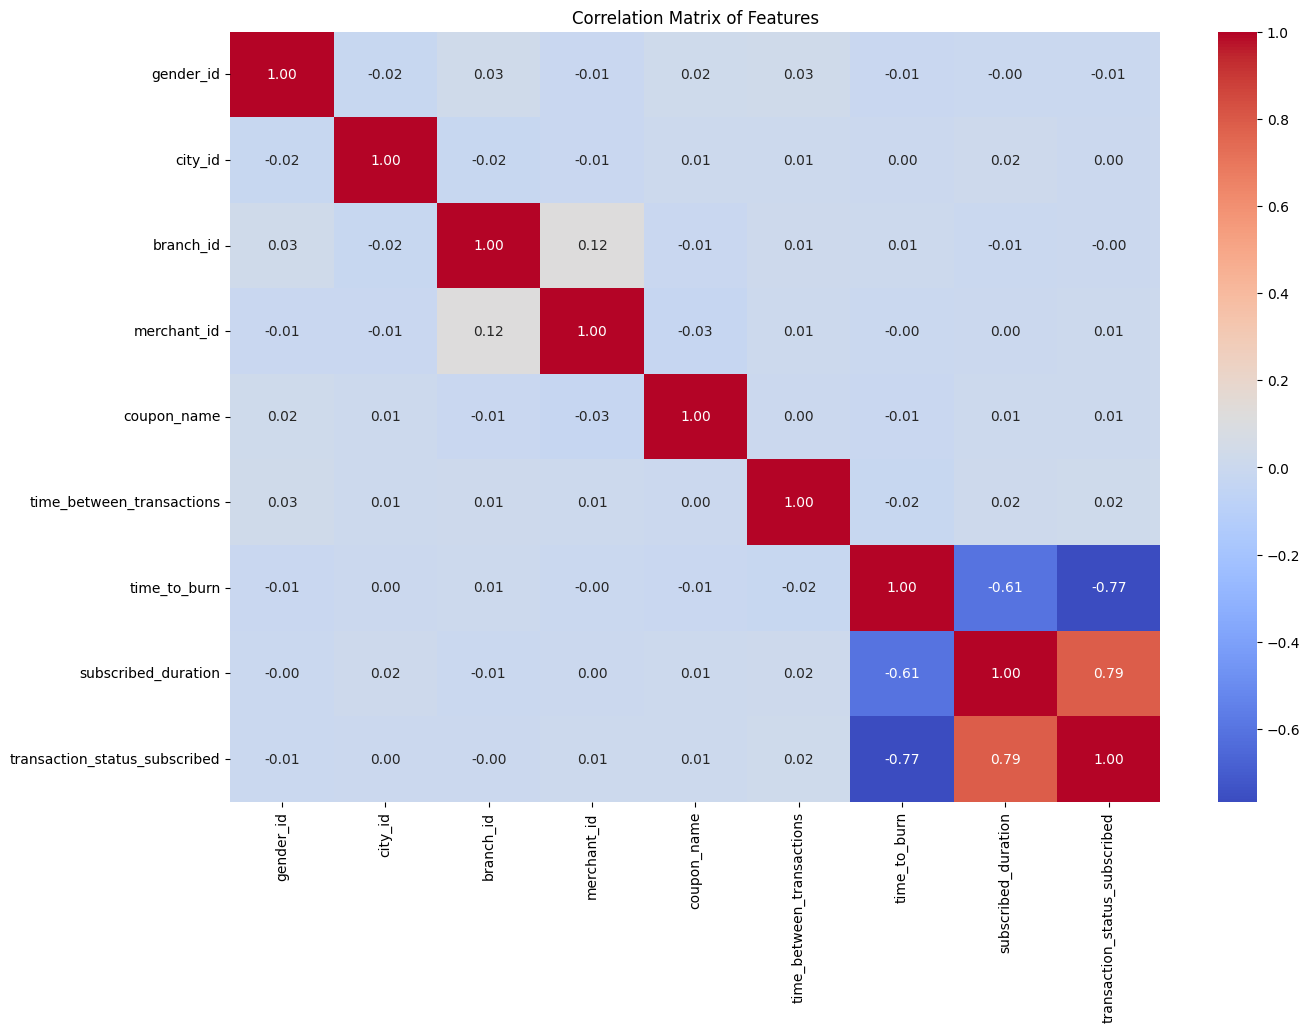

In [93]:

# Calculate the correlation matrix
correlation_matrix = df.corr()

# You can also visualize the correlation matrix using a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


transaction_status_subscribed  with time_to_burn , subscribed_duration                 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   gender_id                  5000 non-null   object
 1   city_id                    5000 non-null   object
 2   branch_id                  5000 non-null   object
 3   merchant_id                5000 non-null   object
 4   coupon_name                5000 non-null   object
 5   time_between_transactions  5000 non-null   object
 6   time_to_burn               5000 non-null   object
 7   subscribed_duration        5000 non-null   object
dtypes: object(8)
memory usage: 312.6+ KB
None


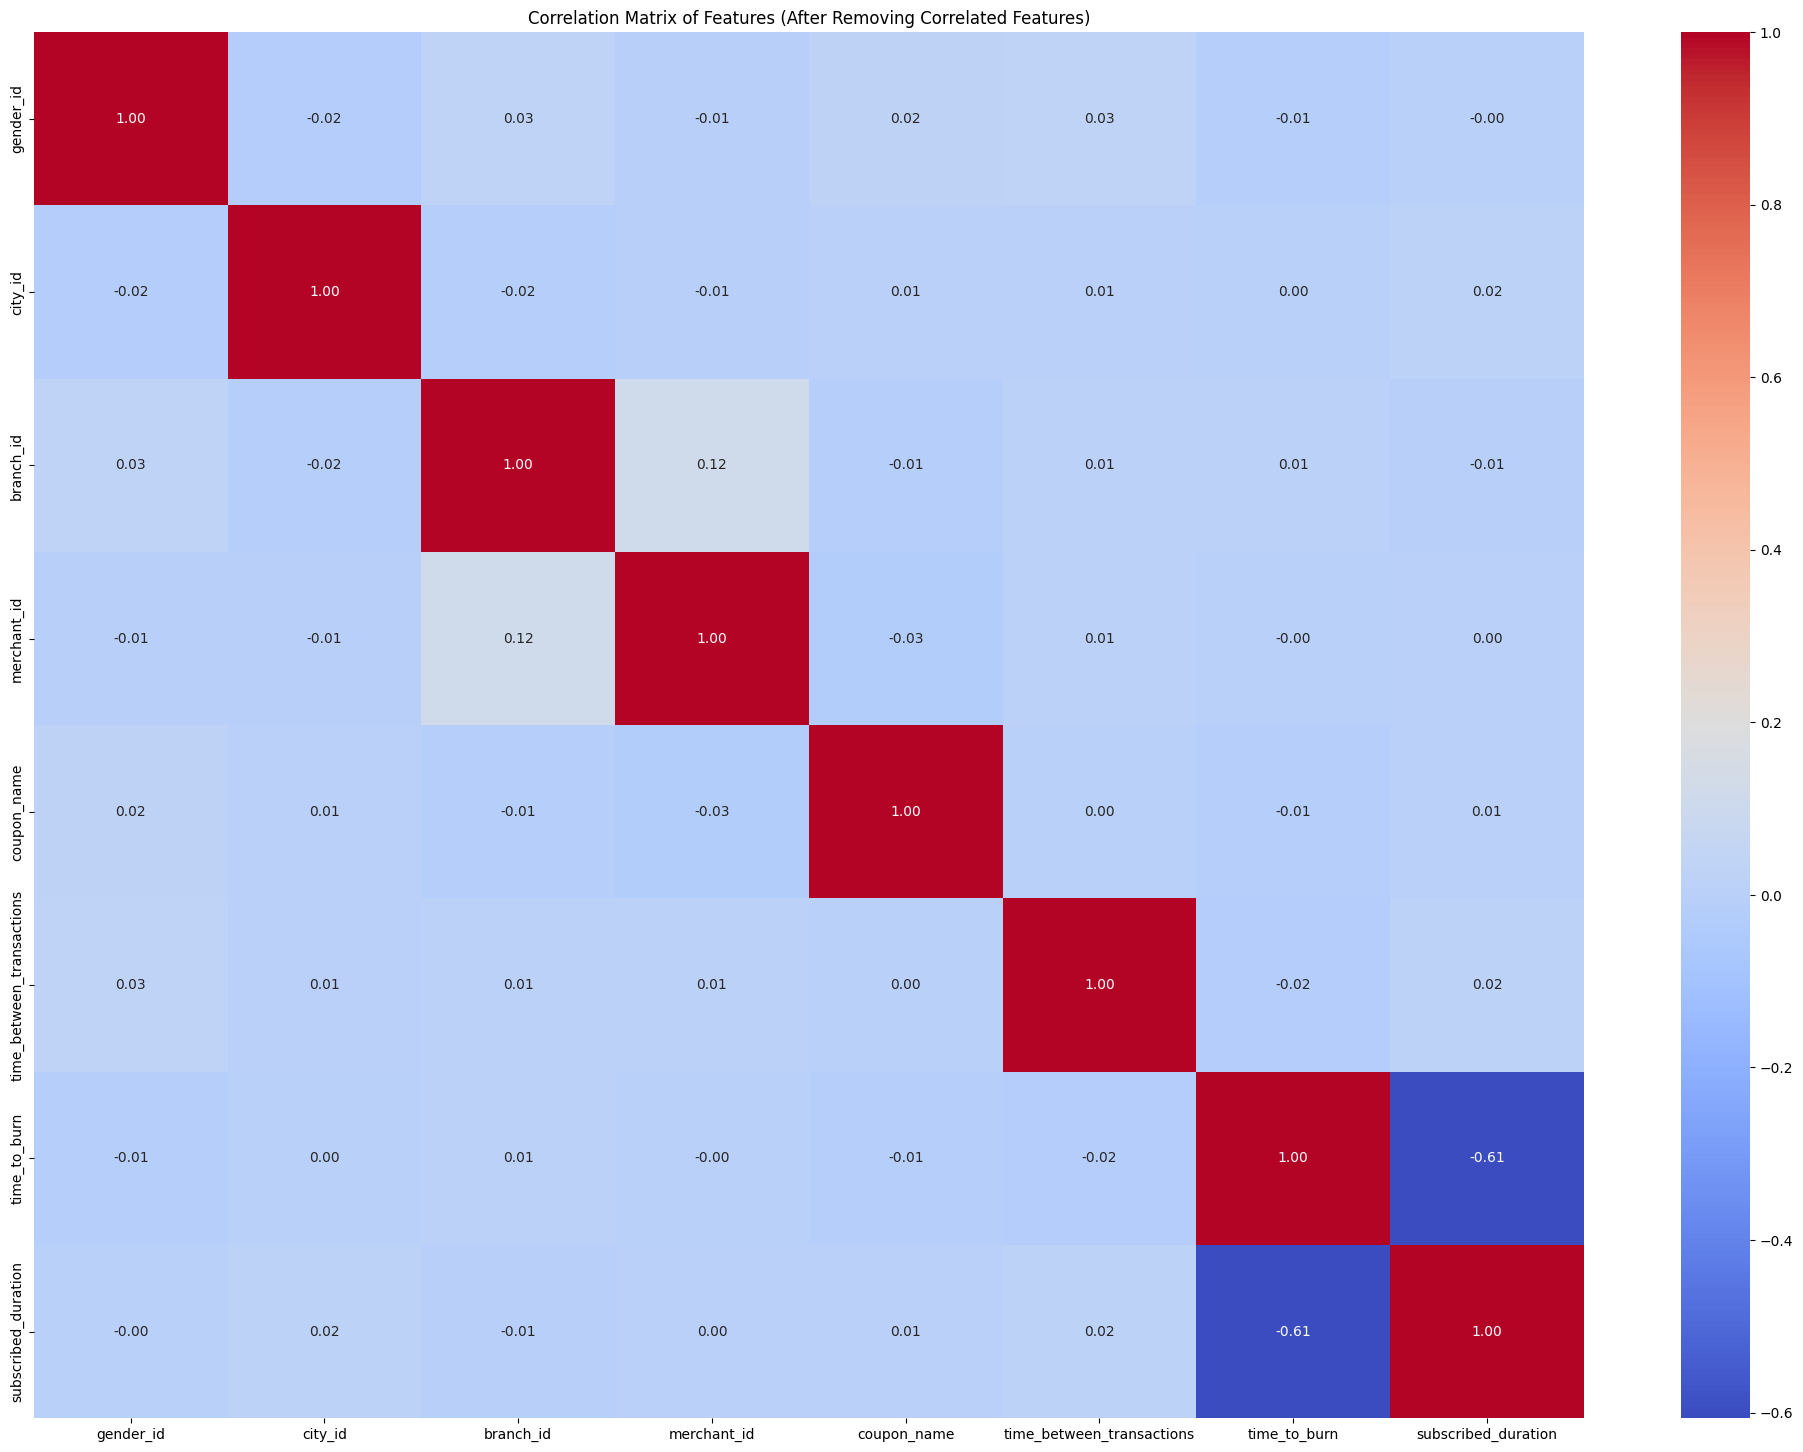

In [94]:


# Remove highly correlated features
df.drop(columns='transaction_status_subscribed', inplace=True)

print(df.info())

# Recalculate the correlation matrix (optional)
correlation_matrix = df.corr()
plt.figure(figsize=(25, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features (After Removing Correlated Features)')
plt.show()


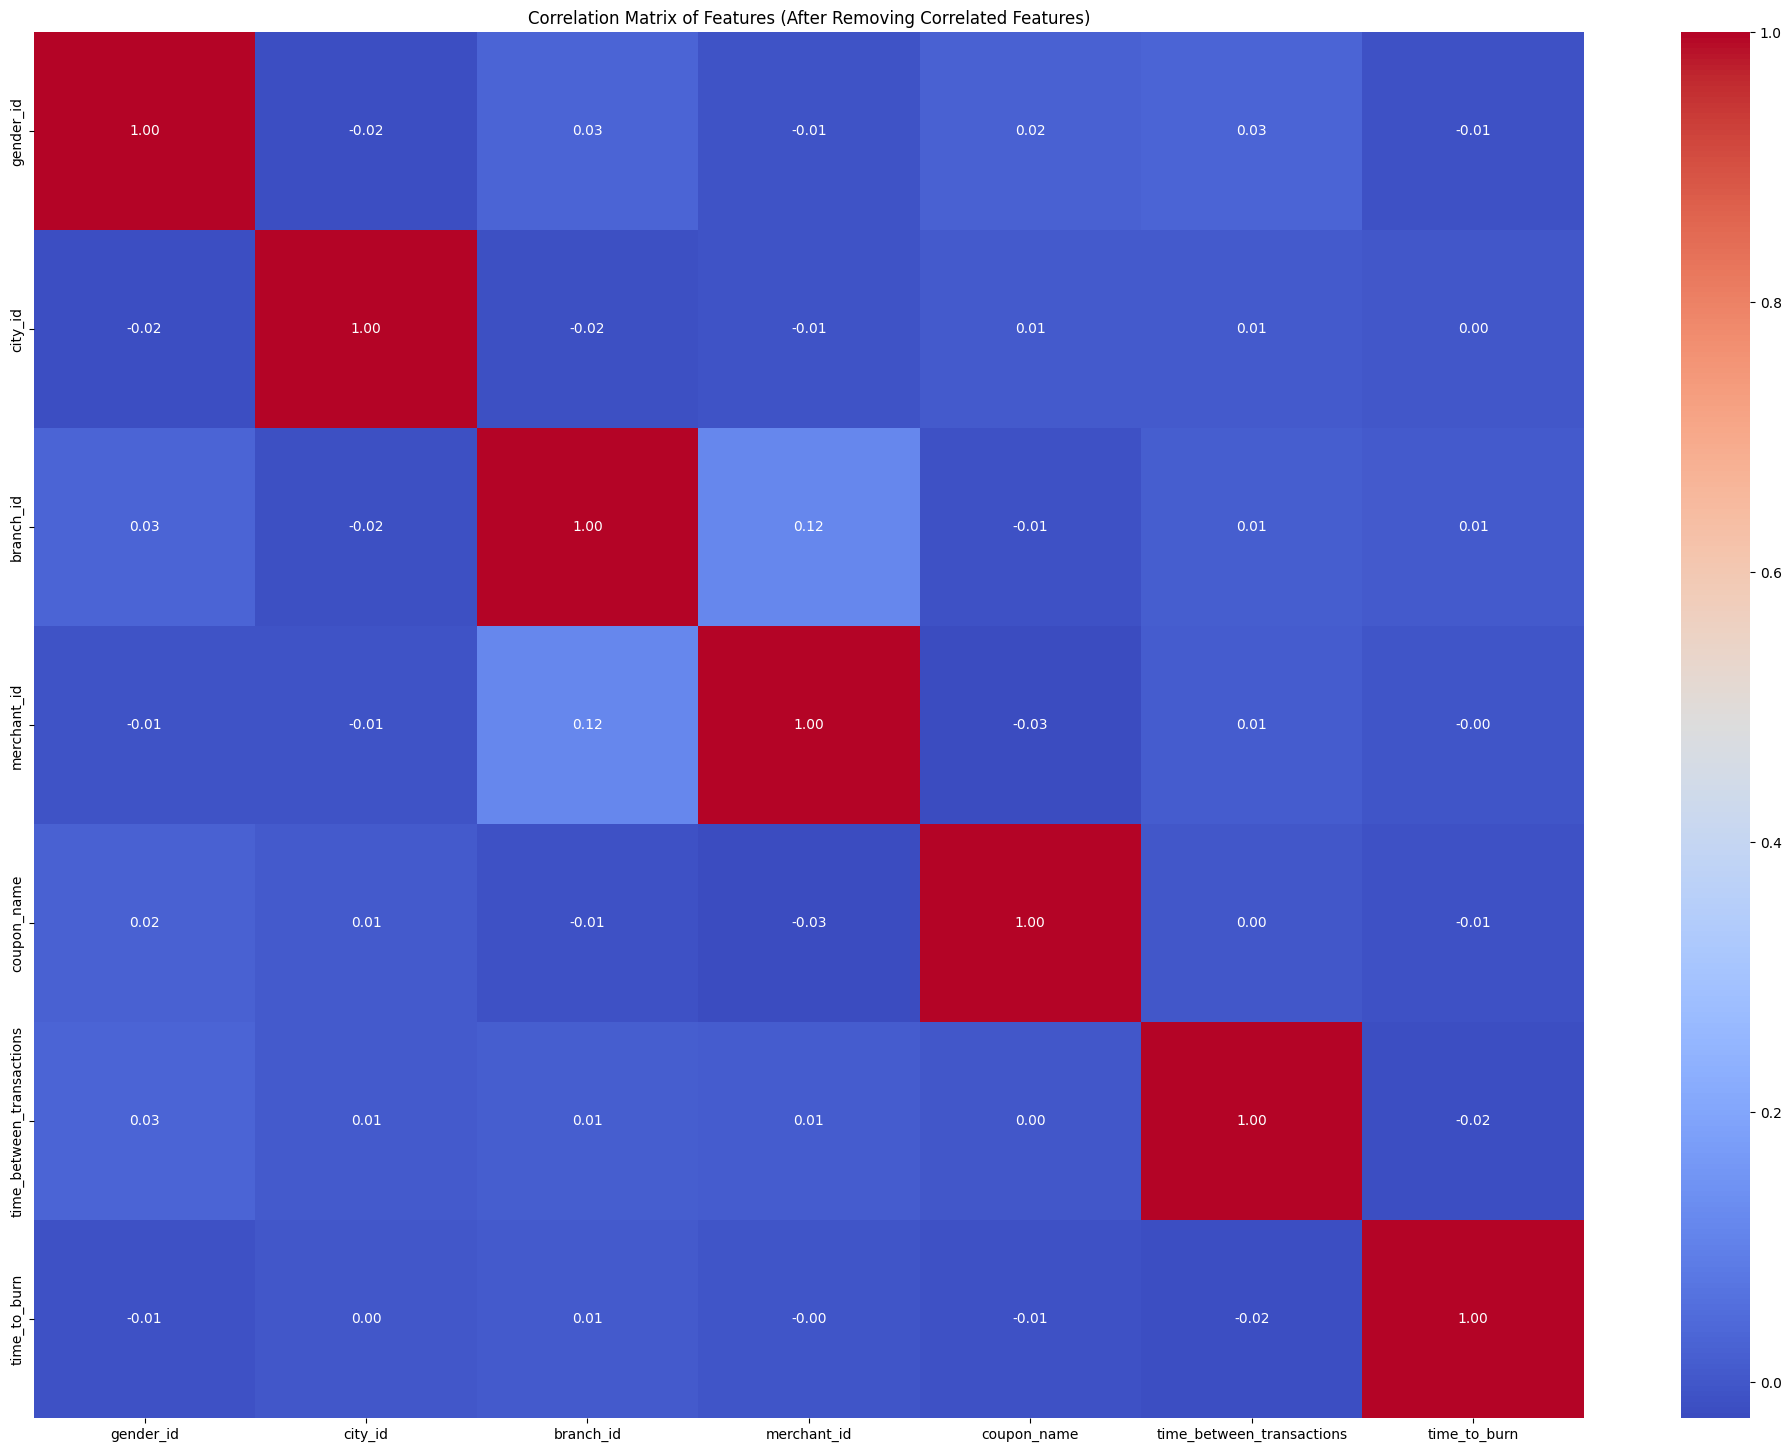

In [95]:
df.drop(columns='subscribed_duration', inplace=True)
# Recalculate the correlation matrix (optional)
correlation_matrix = df.corr()
plt.figure(figsize=(25, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features (After Removing Correlated Features)')
plt.show()

In [96]:
# Scaling Numerical Features
# Normalize numerical features using MinMaxScaler (K-Means benefits from scaled data).

columns = df.columns

# Scaling numerical features
scaler = StandardScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender_id                  5000 non-null   float64
 1   city_id                    5000 non-null   float64
 2   branch_id                  5000 non-null   float64
 3   merchant_id                5000 non-null   float64
 4   coupon_name                5000 non-null   float64
 5   time_between_transactions  5000 non-null   float64
 6   time_to_burn               5000 non-null   float64
dtypes: float64(7)
memory usage: 273.6 KB
None


# Model Development (Unsupervised Learning)

K-Means (Partition-based)

DBSCAN (Density-based)

Hierarchical Clustering (Agglomerative approach)

Finding Optimal Clusters for K-Means
- Elbow Method (using Inertia)
- Silhouette Score (to measure clustering quality)

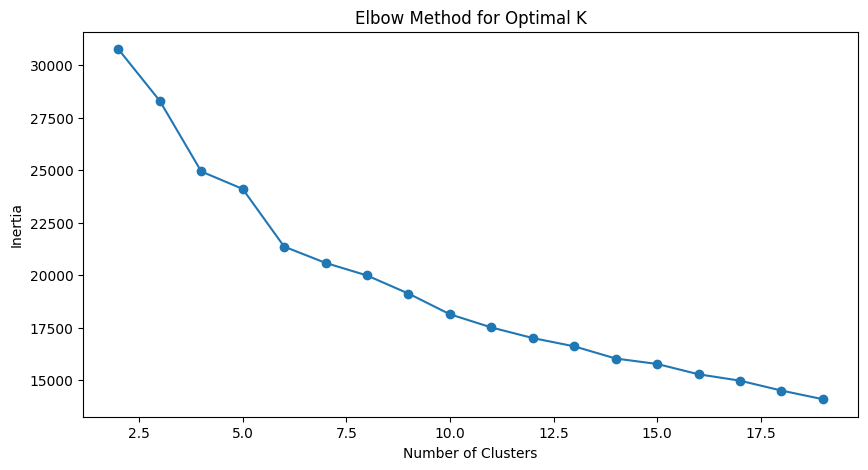

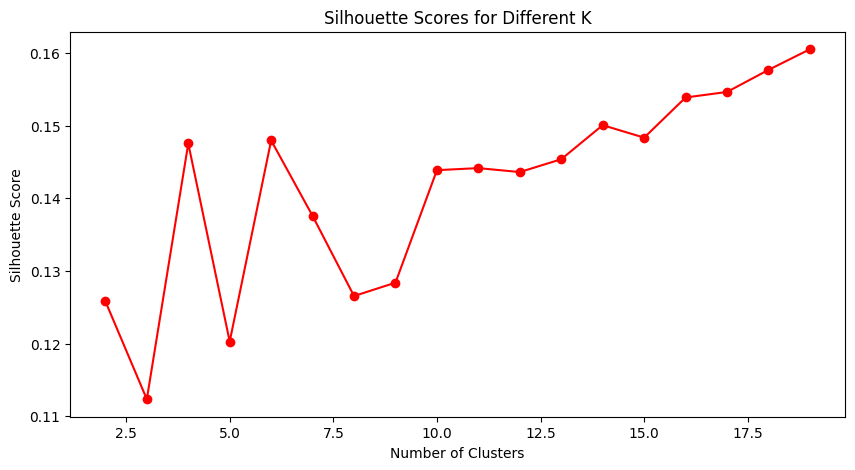

In [98]:

inertia = []
silhouette_scores = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df, cluster_labels))

# Plot Elbow Method
plt.figure(figsize=(10,5))
plt.plot(range(2,20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10,5))
plt.plot(range(2,20), silhouette_scores, marker='o', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K')
plt.show()

data visualization

<ipython-input-99-1e16ae1124ec>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], palette='tab10', s=50) # Now using column names
<ipython-input-99-1e16ae1124ec>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Cluster")


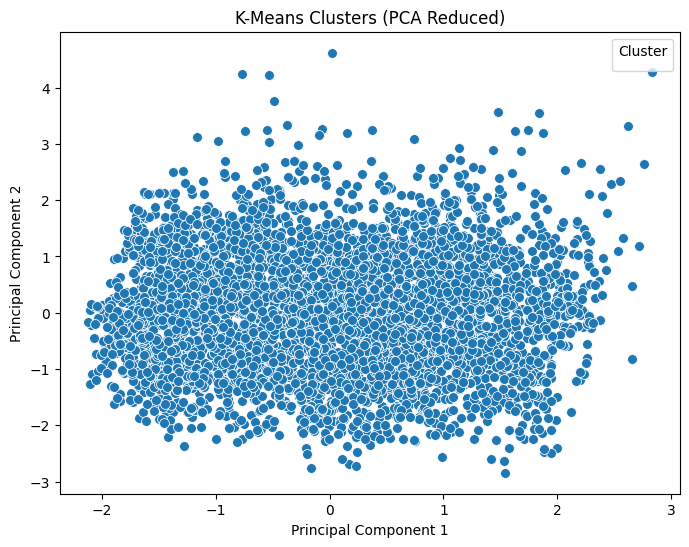

In [99]:
# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)  # Drop cluster column if exists

# Convert to DataFrame with column names
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Plot PCA-based clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], palette='tab10', s=50) # Now using column names
plt.title("K-Means Clusters (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

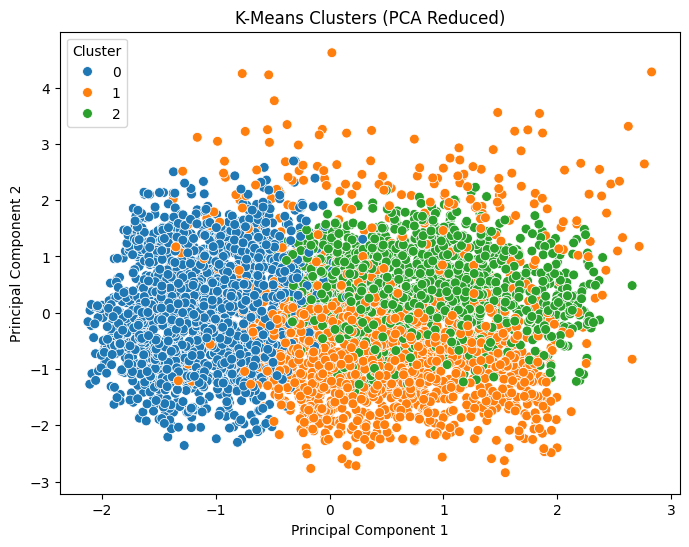

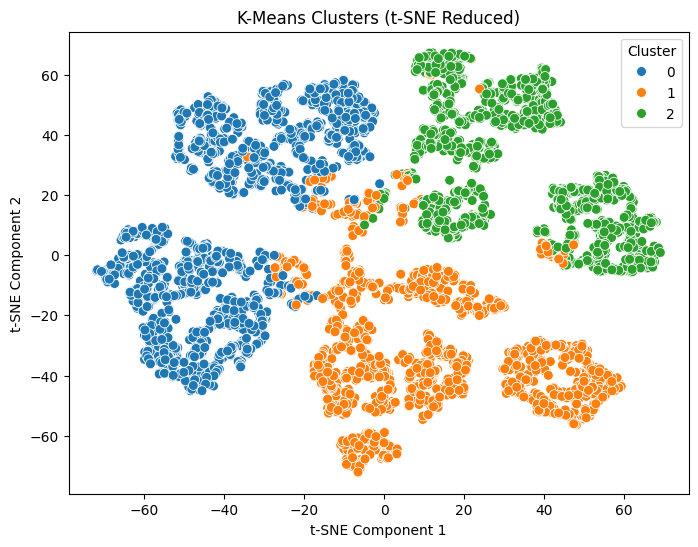

In [103]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming df is already preprocessed and scaled
k = 3  # Optimal K
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df)

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.drop(columns=['Cluster']))  # Drop cluster column

# Convert to DataFrame
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df['Cluster']

# Plot PCA-based clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['Cluster'], palette='tab10', s=50)
plt.title("K-Means Clusters (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Apply t-SNE for better separation
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
df_tsne = tsne.fit_transform(df.drop(columns=['Cluster']))

# Convert to DataFrame
df_tsne = pd.DataFrame(df_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = df['Cluster']

# Plot t-SNE-based clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_tsne['TSNE1'], y=df_tsne['TSNE2'], hue=df_tsne['Cluster'], palette='tab10', s=50)
plt.title("K-Means Clusters (t-SNE Reduced)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.show()

Cluster Profiling: Understanding Each Cluster

Model Training & Evaluation using:
- Inertia (lower is better)
- Silhouette Score (higher is better)
- DBSCAN clustering density (if using DBSCAN)

In [104]:
print(df['Cluster'].value_counts())
cluster_summary = df.groupby('Cluster').mean()
cluster_summary


Cluster
0    1882
1    1736
2    1382
Name: count, dtype: int64


,gender_id,city_id,branch_id,merchant_id,coupon_name,time_between_transactions,time_to_burn
Cluster,,,,,,,
0,-0.005083,0.019334,-0.542651,-1.026827,0.044096,-0.195316,-0.004317
1,-0.812201,0.008221,0.270813,0.592130,-0.029416,0.330084,-0.012500
2,1.027169,-0.036656,0.398797,0.654522,-0.023099,-0.148654,0.021580


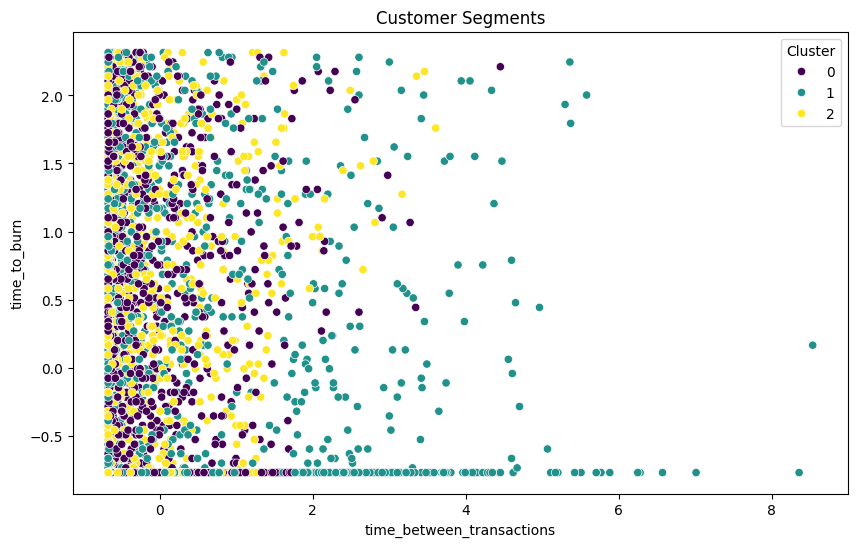

Cluster 1 contains 1736 customers
Less frequent transactions, some branch/merchant preference
Cluster 0 contains 1882 customers
Steady engagement, moderate transactions
Cluster 2 contains 1382 customers
Frequent transactions, high engagement with branches/merchants


In [108]:
# Visualizing Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['time_between_transactions'], y=df['time_to_burn'], hue=df['Cluster'], palette='viridis')
plt.title('Customer Segments')
plt.show()

# Coupon Strategy Recommendation
for cluster in df['Cluster'].unique():
    segment_size = len(df[df['Cluster'] == cluster])
    print(f"Cluster {cluster} contains {segment_size} customers")

    if cluster == 0:
        print("Steady engagement, moderate transactions")
    elif cluster == 1:
        print("Less frequent transactions, some branch/merchant preference")
    else:
        print("Frequent transactions, high engagement with branches/merchants")


# Customer Segment Analysis
- Assign clusters to customers.
- Visualize clusters using TSNE/PCA.
- Analyze patterns:
    1. Which group burns coupons more?
    2. Which group has the longest subscription duration?
    3. Which cities/genders dominate certain clusters?

In [ ]:
# future steps